# Decoder Classifier

## Data Cleaning

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

In [ ]:
import pandas as pd

# Load the dataset
reddit_comments = pd.read_csv('Data/r_ubc_comments.csv')
reddit_posts = pd.read_csv("Data/r_ubc_posts.csv")

In [ ]:
# Merging datasets
reddit_data = reddit_posts.merge(reddit_comments.groupby("post_id")["body"].apply(lambda x: " ".join(x)), left_on="id", right_on ='post_id', how="left")
reddit_data["full_text"] = reddit_data['title'] + ['    '] + reddit_data["selftext"].fillna('') + ['    '] + reddit_data["body"].fillna('')

In [ ]:
# Convert from UTC to detailed month, date, day of week and hour
reddit_data['created_utc'] = pd.to_datetime(
    reddit_data['created_utc'], 
    unit='s',  # Timestamp is in seconds
    utc=True    # Enforce UTC timezone
)

reddit_data['month'] = reddit_data['created_utc'].dt.month_name() 
reddit_data['date'] = reddit_data['created_utc'].dt.day            
reddit_data['day_of_week'] = reddit_data['created_utc'].dt.day_name()  
reddit_data['hour'] = reddit_data['created_utc'].dt.hour           

Here we used a pre-trained model from hugging face to generate sentiment labels for each posts. 

Notice that for posts without texts we mark them as "neutral".

In [ ]:
# Generate sentiment label for the data
from transformers import pipeline

emotion_classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")

reddit_data["sentiment"] = reddit_data["full_text"].apply(lambda x: emotion_classifier(x[:512])[0]["label"] if pd.notna(x) else "neutral")

In [ ]:
import re

def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()                         
        text = re.sub(r"http\S+", "", text)         
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
        return text.strip()                         
    else:
        return ""                      

reddit_data["clean_text"] = reddit_data["full_text"].apply(clean_text)

In [ ]:
reddit_data = reddit_data.rename(columns = {'sentiment': 'label', 'clean_text': 'text'})

In [ ]:
reddit_data.to_csv('Data/r_reddit_data.csv', index=False)

In [3]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files="Data/r_reddit_data.csv")['train']

In [4]:
# Split training and testing data
split_dataset = dataset.train_test_split(
    test_size=0.2,   
    seed=42                
)

train_data = split_dataset["train"]
test_data = split_dataset["test"]

In [33]:
import pandas as pd

# Check the distribution of labels from the training set
train_labels = pd.Series(train_data["label"])
print("Training Set:\n",train_labels.value_counts(normalize=True))

# Check the distribution of labels from the testing set
test_labels = pd.Series(test_data["label"])
print("Testing Set:\n",test_labels.value_counts(normalize=True))

Training Set:
 joy         0.586076
anger       0.168354
sadness     0.125316
fear        0.089873
surprise    0.021519
love        0.008861
Name: proportion, dtype: float64
Testing Set:
 joy         0.515152
anger       0.171717
fear        0.146465
sadness     0.095960
surprise    0.040404
love        0.030303
Name: proportion, dtype: float64


We can visualize the share of different labels with a pie chart.

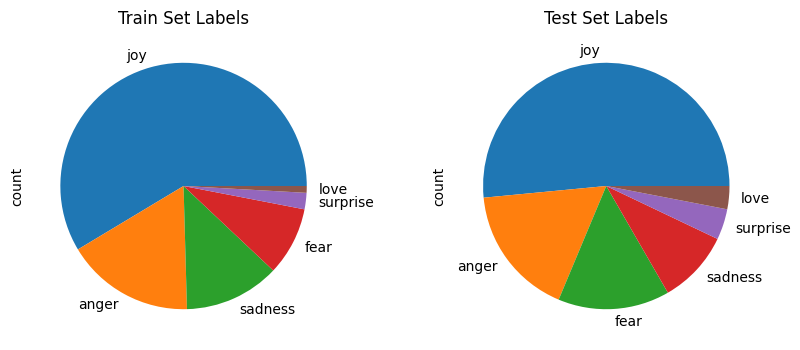

In [ ]:
# Visualizing label distributions
import matplotlib.pyplot as plt
import pandas as pd

train_counts = pd.Series(train_data["label"]).value_counts()
test_counts = pd.Series(test_data["label"]).value_counts()

# Plot the Pie Chart
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
train_counts.plot.pie(title="Train Set Labels")
plt.subplot(1,2,2)
test_counts.plot.pie(title="Test Set Labels")
plt.show()

## Training Classifier

### 1. OneVsRestClassifier

This is our first classifying strategy, which consists in fitting one binary classifier per class.

For example, if you want to classify 3 types of fruits, apple, banana and orange with this strategy, you will need to train 3 binary classifiers. The first of these classifiers determines if it is an apple, the second is responsible for determining if it is a banana, and the third is responsible for determining if it is an orange.

The 3 classifiers will then vote for the given new observation, the voting result will be shown as probability. Let's say we have a new observation that we are unsure what type of fruit it is, so we feed this observation to our classifier. The "Apple" classifier claims it's 80% likely an apple, the "Banana" classifier claims it's 10% likely a banana, and the "Orange" classifier claims it's 50% likely an orange. Then we classify based on the highest probability that our new object is an apple.

While it is simple and effective, this strategy has its drawback -- What if there are large amount of labels for us to classify? What if the labels have specific hierarchies? In the first situation, it may take a lot of time to train multiple classifiers for this task; and in the second situation, we could make a lot of mistakes using binary classification. Then we'd better use alternative strategies. 

Anyhow, this is a good way to begin encoder classification.

### 2. MultiOutputClassifier 

### 3. ClassifierChain

Here, we will show how to train a basic encoder for our purposes using an example. Before we begin, we need to install the necessary package.
```bash
$ pip install setfit
```

In [7]:
import torch

torch.cuda.empty_cache()

training_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(torch.version.cuda)
print(torch.__version__)

None
2.5.1+cpu


In [8]:
print(torch.cuda.is_available())  

print(torch.cuda.device_count())

print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

False
0


AssertionError: Torch not compiled with CUDA enabled

In [9]:
print(torch.cuda.memory_allocated() / 1024**3, "GB")
print(torch.cuda.max_memory_allocated() / 1024**3, "GB")

0.0 GB
0.0 GB


In [10]:
# Set RAM distribution strategy
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("PYTORCH_CUDA_ALLOC_CONF:", os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

PYTORCH_CUDA_ALLOC_CONF: expandable_segments:True


In [11]:
from setfit import SetFitModel
# model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Here we use a pre-trained model for classification, you can also find other models on https://huggingface.co/ 
model = SetFitModel.from_pretrained(model_id, device="cpu", max_seq_length=256)

model.model_head

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kaiyan Zhang\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


LogisticRegression()

In [12]:
from setfit import SetFitTrainer

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=test_data,
    batch_size = 16,
    num_epochs = 3,
    use_amp=True,
    metric = 'accuracy'
)

C:\Users\Kaiyan Zhang\AppData\Local\Temp\ipykernel_19652\2009668260.py:3: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [ ]:
trainer.train()

In [ ]:
model = SetFitModel.from_pretrained("my_setfit_model")

preds = model.predict(test_data['text'])

In [25]:
metrics = trainer.evaluate()

metrics

***** Running evaluation *****


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [18]:
# Save our model
model.save_pretrained("./my_setfit_model")

SafetensorError: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "请求的操作无法在使用用户映射区域打开的文件上执行。" })

After saving our first model, we need to check the quality of the data.

A counfusion matrix analysis may be informative. You may need to install the following package
```bash
$ pip install seaborn
```

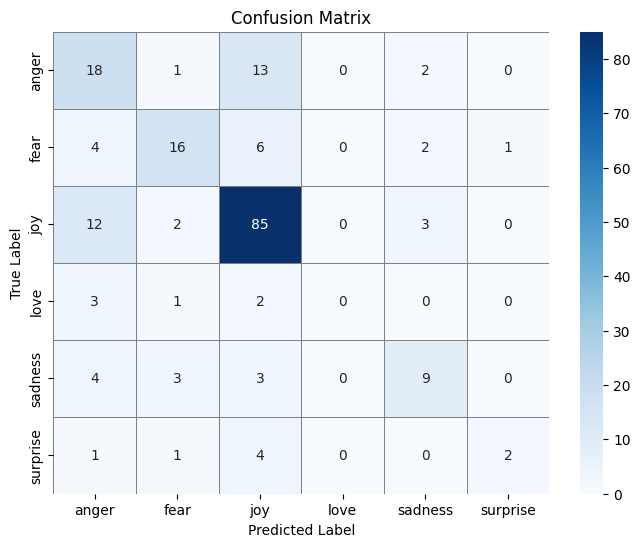

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
y_true = test_data["label"]
y_pred = model.predict(test_data["text"])

# sort labels
classes = sorted(set(y_true)) 

cm = confusion_matrix(y_true, y_pred, labels=classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="gray", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       anger       0.43      0.53      0.47        34
        fear       0.67      0.55      0.60        29
         joy       0.75      0.83      0.79       102
        love       0.00      0.00      0.00         6
     sadness       0.56      0.47      0.51        19
    surprise       0.67      0.25      0.36         8

    accuracy                           0.66       198
   macro avg       0.51      0.44      0.46       198
weighted avg       0.64      0.66      0.64       198



c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kaiyan Zhang\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

By looking at this confusion matrix and the classification report, we now realize a key disadvantage of our current model lies in correctly classifying anger.

Another way of checking is to look at the baseline model accuracy 

In [31]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified")
dummy.fit(train_data["text"], train_data["label"])
baseline_acc = dummy.score(test_data["text"], test_data["label"])
print(f'Baseline Model Accuracy: {baseline_acc:.4f}')

Baseline Model Accuracy: 0.3485


In our case, we see the baseline model accuracy is 0.3889, therefore, our training model made about 0.27 accuracy improvement from the base model.

## Reference